In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [2]:
u_cols = ["user_id", "age", "sex", "occupation", "zip_code"]
users = pd.read_csv("./data/ml-100k/u.user", sep="|", header=None, names=u_cols, encoding="latin-1")
print("Number of users:", users.shape[0])

#rates
r_cols = ["user_id", "item_id", "rating", "unix_timestamp"]
ratings_base = pd.read_csv("./data/ml-100k/ua.base", sep="\t", header=None, names=r_cols, encoding="latin-1")
ratings_test = pd.read_csv("./data/ml-100k/ua.test", sep="\t", header=None, names=r_cols, encoding="latin-1")
print("Number of ratings in base set:", ratings_base.shape[0])
print("Number of ratings in test set:", ratings_test.shape[0])

#items
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

items = pd.read_csv('./data/ml-100k/u.item', sep='|', names=i_cols, encoding='latin-1')
print("Number of items:", items.shape[0])

Number of users: 943
Number of ratings in base set: 90570
Number of ratings in test set: 9430
Number of items: 1682


In [3]:
user_mean_ratings = ratings_base.groupby('user_id')['rating'].mean()

In [4]:
def pearson_correlation(user1, user2):
    """
    Calculate Pearson correlation between ratings of two users
    
    Parameters:
    user1, user2: user IDs to compare
    
    Returns:
    float: Pearson correlation coefficient between the two users
    """
    # Get items rated by each user
    items_user1 = ratings_base[ratings_base["user_id"] == user1][["item_id", "rating"]]
    items_user2 = ratings_base[ratings_base["user_id"] == user2][["item_id", "rating"]]
    
    # Find common items
    common_items = pd.merge(items_user1, items_user2, on="item_id", suffixes=('_user1', '_user2'))

    # If less than 3 common items, return 0 (not enough data for reliable correlation)
    if len(common_items) < 3:
        return 0
    
    # Get mean ratings for each user
    mean_rating_user1 = items_user1["rating"].mean()
    mean_rating_user2 = items_user2["rating"].mean()
    
    # Calculate numerator and denominators for Pearson formula
    numerator = sum((common_items["rating_user1"] - mean_rating_user1) * 
                    (common_items["rating_user2"] - mean_rating_user2))
    
    denominator_user1 = sum((common_items["rating_user1"] - mean_rating_user1)**2)**0.5
    denominator_user2 = sum((common_items["rating_user2"] - mean_rating_user2)**2)**0.5
    
    # Check for division by zero
    if denominator_user1 == 0 or denominator_user2 == 0:
        return 0
    
    # Calculate and return correlation
    correlation = numerator / (denominator_user1 * denominator_user2)
    
    # Apply significance weighting (optional but recommended)
    # This gives more weight to correlations based on more common items
    if len(common_items) < 50:
        correlation = correlation * (len(common_items) / 50)
    
    return correlation

In [5]:
class LazySimilarityMatrix:
    def __init__(self):
        self.similarity_cache = {}
        
    def get_similarity(self, user1, user2):
        """Get similarity between two users with caching"""
        if user1 == user2:
            return 1.0
        
        # Use a consistent order for the key to avoid duplicates
        cache_key = tuple(sorted([user1, user2]))
        
        if cache_key not in self.similarity_cache:
            sim = pearson_correlation(user1, user2)
            self.similarity_cache[cache_key] = sim
            
        return self.similarity_cache[cache_key]
    
    def get_top_k_similar_users(self, user_id, k=20, exclude_negative=True):
        """Find k users most similar to the given user"""
        user_ids = ratings_base["user_id"].unique()
        similarities = []
        
        for other_user_id in user_ids:
            if other_user_id != user_id:
                sim = self.get_similarity(user_id, other_user_id)
                # Option to exclude users with negative correlation
                if not exclude_negative or sim > 0:
                    similarities.append((other_user_id, sim))
        
        # Sort by similarity (descending) and take top k
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:k]

In [6]:
similarity_matrix = LazySimilarityMatrix()

In [7]:
user_mean_ratings = ratings_base.groupby('user_id')['rating'].mean()

Hàm dự đoán có thêm trường depth để thực hiện đệ quy

In [8]:
def predict_rating(user_id, item_id, k=20, depth=2, visited=None, rating_range=(1, 5)):
    """
    Predict rating for a given user-item pair using user-based collaborative filtering
    
    Parameters:
    user_id: ID of the user
    item_id: ID of the item
    k: Number of similar users to consider
    rating_range: Valid range for ratings (min, max)
    
    Returns:
    float: Predicted rating
    """
    # Get mean rating for the current user
    if user_id in user_mean_ratings:
        mean_rating_user = user_mean_ratings[user_id]
    else:
        mean_rating_user = ratings_base['rating'].mean()  # Global mean as fallback
    
    # Check if the user has already rated this item
    is_rated = ratings_base[(ratings_base['user_id'] == user_id) & (ratings_base['item_id'] == item_id)]
    if not is_rated.empty:
        return is_rated['rating'].iloc[0]
    
    if visited is None:
        visited = set()
    
    if (user_id, item_id) in visited or depth == 0:
        return mean_rating_user
    
    visited.add((user_id, item_id))
    
    # Get k most similar users
    similar_users = similarity_matrix.get_top_k_similar_users(user_id, k)
    
    numerator = 0
    denominator = 0
    
    for neightbor_id, sim in similar_users:
        neightbor_rating = ratings_base[(ratings_base['user_id'] == neightbor_id) & (ratings_base['item_id'] == item_id)]
        if neightbor_rating.empty:
            pred_rating = predict_rating(neightbor_id, item_id, k, depth-1, visited)
            neighbor_mean = user_mean_ratings[neightbor_id]
            neighbor_diff = pred_rating - neighbor_mean
        else:
            neighbor_diff = neightbor_rating['rating'].iloc[0] - user_mean_ratings[neightbor_id]
        
        numerator += sim * neighbor_diff
        denominator += abs(sim)
    
    if denominator == 0:
        return mean_rating_user

    predicted = mean_rating_user + (numerator / denominator)
    predicted = max(min(predicted, rating_range[1]), rating_range[0])
    
    return predicted
    

In [9]:
from tqdm import tqdm
def evaluate_model(val_set, k=20, metric='rmse'):
    """
    Evaluate the recommender model on the test set
    
    Parameters:
    k: Number of similar users to consider
    metric: Evaluation metric ('rmse' or 'mae')
    
    Returns:
    float: Error metric value (lower is better)
    """
    errors = []
    total = len(val_set)
    print(f"Evaluating model with k={k} on {total} test samples...")
    
    # Optional: show progress for long evaluations
    progress_step = max(1, total // 10)
    
    with tqdm(total=total, desc="Evaluating", ncols=100, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:
        for _, row in ratings_test.iterrows():
            user_id, item_id, actual_rating = row['user_id'], row['item_id'], row['rating']
            predicted_rating = predict_rating(user_id, item_id, k)

            if metric == 'rmse':
                errors.append((predicted_rating - actual_rating) ** 2)
            else:  # mae
                errors.append(abs(predicted_rating - actual_rating))
            
            pbar.update(1)
            
    if metric == 'rmse':
        return np.sqrt(np.mean(errors))
    else:  # mae
        return np.mean(errors)

In [18]:
def find_optimal_k(k_values=None, num_folds=5, depth=1, metric='rmse', n_jobs=-1, random_state=42):
    """
    Find the optimal k value for the KNN algorithm using k-fold cross-validation.
    Returns tuple (best_k, best_error).
    """
    if k_values is None:
        k_values = [5, 10, 20, 30, 40, 50]

    # Prepare cross-validation splits on the base ratings
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    idx = np.arange(len(ratings_base))

    results = []
    for k in tqdm(k_values, desc="Optimizing k via CV"):
        fold_errs = []
        for train_idx, val_idx in kf.split(idx):
            train_df = ratings_base.iloc[train_idx].reset_index(drop=True)
            val_df = ratings_base.iloc[val_idx].reset_index(drop=True)
            err = evaluate_model(val_df, k=k, metric=metric)
            fold_errs.append(err)
        avg_err = np.mean(fold_errs)
        results.append((k, avg_err))
        print(f"k={k}, avg {metric}={avg_err:.4f}")

    # Plot results
    import matplotlib.pyplot as plt
    ks = [r[0] for r in results]
    errs = [r[1] for r in results]
    plt.figure(figsize=(10,6))
    plt.plot(ks, errs, marker='o')
    plt.xlabel('k (Number of neighbors)')
    plt.ylabel(metric.upper())
    plt.title(f'{metric.upper()} vs k ({num_folds}-fold CV)')
    plt.grid(True)
    plt.savefig('RecursiveCF-KNN_optimization.png')
    plt.show()

    # Select best k
    best_k, best_err = min(results, key=lambda x: x[1])
    return best_k, best_err

In [11]:
def recommend_items(user_id, n=10, exclude_rated=True):
    """
    Recommend top N items for a given user
    
    Parameters:
    user_id: ID of the user
    n: Number of recommendations to make
    exclude_rated: Whether to exclude items the user has already rated
    
    Returns:
    list: Tuples of (item_id, predicted_rating)
    """
    # Get all items
    all_items = items['movie id'].unique()
    
    # Get items already rated by the user if we want to exclude them
    if exclude_rated:
        rated_items = ratings_base[ratings_base['user_id'] == user_id]['item_id'].unique()
        candidate_items = [item for item in all_items if item not in rated_items]
    else:
        candidate_items = all_items
    
    # Predict ratings for candidate items
    predictions = []
    for item_id in candidate_items:
        pred_rating = predict_rating(user_id, item_id)
        predictions.append((item_id, pred_rating))
    
    # Sort by predicted rating (descending) and take top n
    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n]

In [12]:
pred = predict_rating(2, 281)
print(f"Predicted rating for user 2, item 281: {pred:.2f}")

Predicted rating for user 2, item 281: 3.36


In [14]:
error = evaluate_model(ratings_test, k=5, metric='rmse')
print(f"RMSE with k=5: {error:.4f}")

Evaluating model with k=5 on 9430 test samples...


Evaluating: 100%|███████████████████████████████████████████████| 9430/9430 [38:43<00:00,  4.06it/s]

RMSE with k=5: 0.9939


Optimizing k via CV:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating model with k=10 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [18:15<16:48,  8.61it/s]


Evaluating model with k=10 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [16:46<15:27,  9.36it/s]


Evaluating model with k=10 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [10:06<09:18, 15.55it/s]


Evaluating model with k=10 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [09:47<09:00, 16.05it/s]


Evaluating model with k=10 on 18114 test samples...


Optimizing k via CV:  20%|██        | 1/5 [1:04:35<4:18:22, 3875.68s/it]

k=10, avg rmse=0.9797
Evaluating model with k=15 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [15:42<14:27, 10.01it/s]


Evaluating model with k=15 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [13:53<12:47, 11.31it/s]


Evaluating model with k=15 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [13:52<12:46, 11.33it/s]


Evaluating model with k=15 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [14:00<12:54, 11.21it/s]


Evaluating model with k=15 on 18114 test samples...


Optimizing k via CV:  40%|████      | 2/5 [2:16:07<3:26:00, 4120.24s/it]

k=15, avg rmse=0.9756
Evaluating model with k=20 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [23:18<21:27,  6.74it/s]


Evaluating model with k=20 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [23:32<21:41,  6.67it/s]


Evaluating model with k=20 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [23:49<21:56,  6.60it/s]


Evaluating model with k=20 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [24:11<22:16,  6.50it/s]


Evaluating model with k=20 on 18114 test samples...


Optimizing k via CV:  60%|██████    | 3/5 [4:15:12<3:03:23, 5501.64s/it]

k=20, avg rmse=0.9748
Evaluating model with k=25 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [36:20<33:27,  4.33it/s]


Evaluating model with k=25 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [36:21<33:29,  4.32it/s]


Evaluating model with k=25 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [37:19<34:22,  4.21it/s]


Evaluating model with k=25 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [36:41<33:47,  4.28it/s]


Evaluating model with k=25 on 18114 test samples...


Optimizing k via CV:  80%|████████  | 4/5 [7:18:37<2:07:54, 7674.34s/it]

k=25, avg rmse=0.9751
Evaluating model with k=30 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [50:40<46:40,  3.10it/s]


Evaluating model with k=30 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [50:16<46:17,  3.13it/s]


Evaluating model with k=30 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [49:49<45:52,  3.15it/s]


Evaluating model with k=30 on 18114 test samples...


Evaluating:  52%|███████████████████████▉                      | 9430/18114 [49:25<45:31,  3.18it/s]


Evaluating model with k=30 on 18114 test samples...


Optimizing k via CV: 100%|██████████| 5/5 [11:24:20<00:00, 8212.11s/it] 


k=30, avg rmse=0.9753


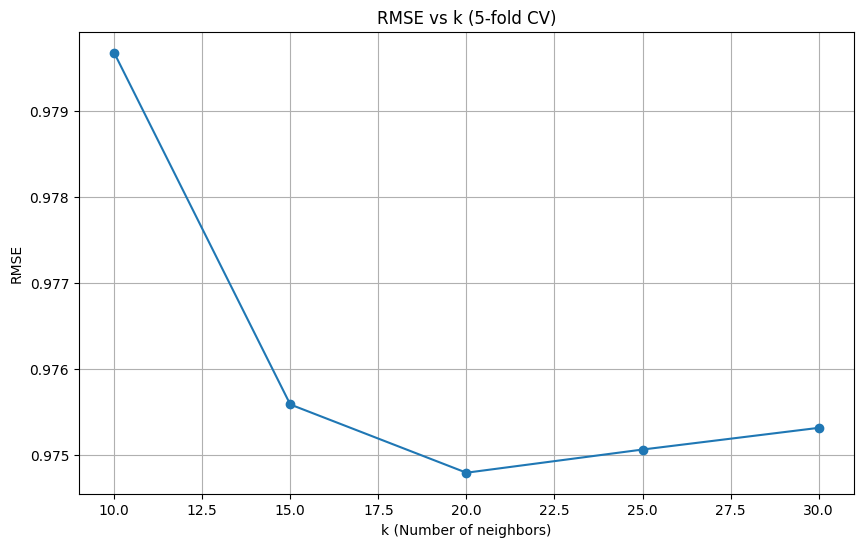

Optimal k: 20 with RMSE: 0.9748


In [19]:
optimal_k, optimal_rmse = find_optimal_k(k_values=[10, 15, 20, 25, 30])
print(f"Optimal k: {optimal_k} with RMSE: {optimal_rmse:.4f}")